# Hacienda el Jobo

Caso: Pronosticar la producción de leche

### 1. Importar librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error

### 2. Carga de datos

In [2]:
df_proyecto = pd.read_csv("/home/daniel/Drive WLS/Cursos/machine-learning/series_de_tiempo/Data/LitrosPorVaca.csv", delimiter=";")
df_proyecto.head()

,Mes,Litros por vaca
0,2007-1,21.6
1,2007-2,20.6
2,2007-3,23.5
3,2007-4,24.1
4,2007-5,26.7


### 3. Tranformacion y limpieza de datos

In [3]:
df_proyecto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Mes              168 non-null    object 
 1   Litros por vaca  168 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.8+ KB


In [4]:
df_proyecto["Mes"]= pd.to_datetime(df_proyecto["Mes"])
df_proyecto.head()

,Mes,Litros por vaca
0,2007-01-01,21.6
1,2007-02-01,20.6
2,2007-03-01,23.5
3,2007-04-01,24.1
4,2007-05-01,26.7


In [5]:
df_proyecto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Mes              168 non-null    datetime64[ns]
 1   Litros por vaca  168 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB


In [6]:
df_proyecto.set_index("Mes", inplace=True)
df_proyecto.head()

,Litros por vaca
Mes,
2007-01-01,21.6
2007-02-01,20.6
2007-03-01,23.5
2007-04-01,24.1
2007-05-01,26.7


### 4. Analisis descriptivo

In [7]:
df_proyecto.describe()

,Litros por vaca
count,168.000000
mean,27.698214
std,3.750968
min,20.300000
25%,24.875000
50%,27.950000
75%,30.225000
max,35.600000


<Axes: xlabel='Mes'>

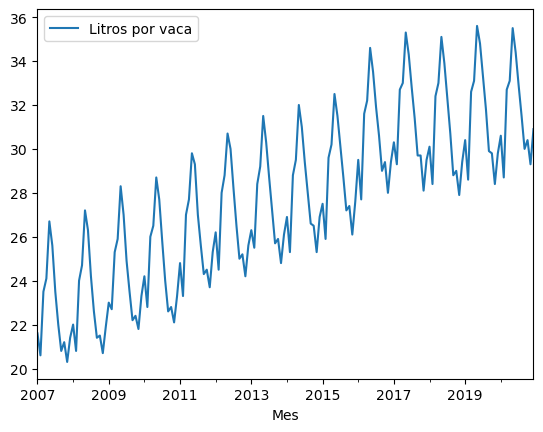

In [8]:
df_proyecto.plot()

In [9]:
serie_de_tiempo = df_proyecto["Litros por vaca"]
type(serie_de_tiempo)

pandas.core.series.Series

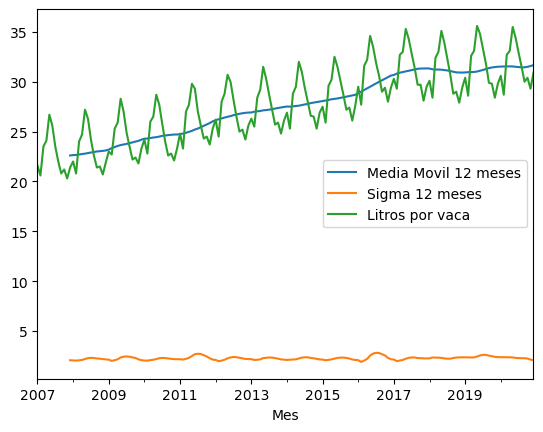

In [10]:
serie_de_tiempo.rolling(12).mean().plot(label="Media Movil 12 meses")
serie_de_tiempo.rolling(12).std().plot(label="Sigma 12 meses")
serie_de_tiempo.plot()
plt.legend()

### 5. Descomposición Estacional

In [11]:
estacional = seasonal_decompose(serie_de_tiempo, period=12)

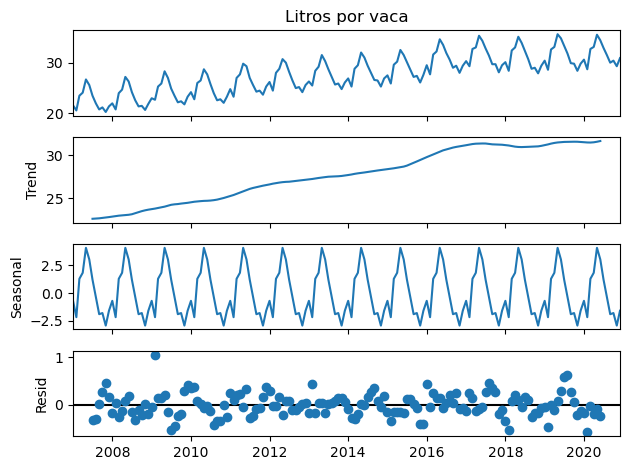

In [12]:
grafico_estacional = estacional.plot()

#### 5.1. Prueba de Dickey-Fuller

La Prueba de Dickey-Fuller Aumentada (ADF, Augmented Dickey-Fuller Test) es una prueba estadística utilizada para determinar si una serie temporal es estacionaria o si tiene una raíz unitaria, lo que indicaría que es no estacionaria.

¿Qué significa que una serie sea estacionaria?
Una serie temporal es estacionaria si sus propiedades estadísticas (como la media, la varianza y la autocorrelación) se mantienen constantes en el tiempo. Esto es importante porque muchos modelos de series temporales, como ARIMA, suponen que los datos son estacionarios.

Ejemplo de series estacionarias y no estacionarias:
Estacionaria: Si una serie oscila alrededor de una media constante con variabilidad estable en el tiempo.
No estacionaria: Si la serie tiene tendencia (crece o decrece con el tiempo) o una varianza cambiante.
¿Cómo funciona la Prueba de Dickey-Fuller?
La prueba ADF evalúa la hipótesis nula (H₀) de que la serie tiene una raíz unitaria, es decir, que no es estacionaria.

Hipótesis nula (H₀): La serie tiene una raíz unitaria (es decir, no estacionaria).

Hipótesis alternativa (H₁): La serie es estacionaria.

Si el p-valor es menor a un umbral (por lo general 0.05), se rechaza H₀, indicando que la serie es estacionaria.

Si el p < 0.05, ¡la serie es estacionaria! y puedes modelar sin transformaciones.

Si el p ≥ 0.05, ¡la serie no es estacionaria!, necesitas aplicar transformaciones antes de modelar.

In [13]:
resultado = adfuller(df_proyecto["Litros por vaca"])
resultado

(-1.2765683449797185,
 0.6398229938263099,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 108.01757657878653)

In [14]:
def prueba_adf(time_series):
    resultado = adfuller(time_series)
    print("Prueba de Dicky-Fuller Aumentado")
    labels = ["Estadistico ADF", "p-value", "# de retrasos", "Observaciones utilizadas"]
    for valor, label in zip(resultado, labels):
        print(label + ":" + str(valor))

    if resultado[1] <= 0.05:
        print("Se rechaza la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("No se puede rechazar hipótesis nula")
        print("Los datos no son estacionarios")

In [15]:
prueba_adf(df_proyecto["Litros por vaca"])

Prueba de Dicky-Fuller Aumentado
Estadistico ADF:-1.2765683449797185
p-value:0.6398229938263099
# de retrasos:13
Observaciones utilizadas:154
No se puede rechazar hipótesis nula
Los datos no son estacionarios


Interpretación de los resultados:

Estadístico ADF: Es el valor de la prueba estadística. Cuanto más negativo sea, mayor será la evidencia de estacionariedad.

p-valor: Si es menor que 0.05, rechazamos la hipótesis nula y concluimos que la serie es estacionaria.

Valores críticos: Son los valores de referencia a distintos niveles de confianza (1%, 5%, 10%).

Decisión:

Si el p < 0.05, ¡la serie es estacionaria! y puedes modelar sin transformaciones.

Si el p ≥ 0.05, ¡la serie no es estacionaria!, necesitas aplicar transformaciones antes de modelar..

#### 5.2 Analisis con diferencias

In [16]:
df_proyecto["Primera diferencia"]= df_proyecto["Litros por vaca"]-df_proyecto["Litros por vaca"].shift(1)
df_proyecto.head(5)

,Litros por vaca,Primera diferencia
Mes,,
2007-01-01,21.6,NaN
2007-02-01,20.6,-1.0
2007-03-01,23.5,2.9
2007-04-01,24.1,0.6
2007-05-01,26.7,2.6


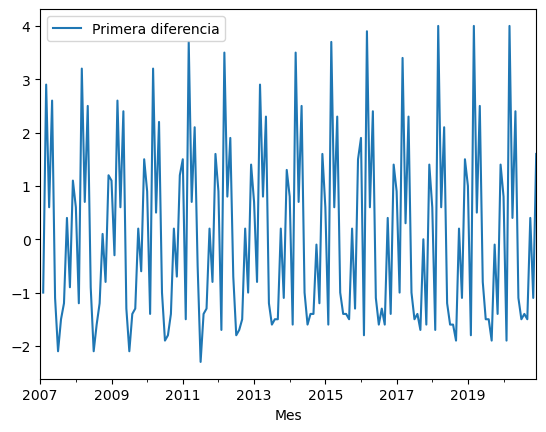

In [17]:
df_proyecto["Primera diferencia"].plot()
plt.legend()
plt.show()

In [18]:
prueba_adf(df_proyecto["Primera diferencia"].dropna())

Prueba de Dicky-Fuller Aumentado
Estadistico ADF:-3.040040217307176
p-value:0.031320592024728824
# de retrasos:14
Observaciones utilizadas:152
Se rechaza la hipótesis nula
Los datos son estacionarios


In [22]:
#df_proyecto["Segunda diferencia"]= df_proyecto["Primera diferencia"]-df_proyecto["Primera diferencia"].shift(1)
#df_proyecto.head(5)

In [23]:
#df_proyecto["Segunda diferencia"].plot()
#plt.legend()
#plt.show()

In [24]:
#prueba_adf(df_proyecto["Segunda diferencia"].dropna())

In [25]:
df_proyecto["Diferecnia Estacionalidad"]= df_proyecto["Litros por vaca"]-df_proyecto["Litros por vaca"].shift(12)
df_proyecto.head(5)

,Litros por vaca,Primera diferencia,Segunda diferencia,Diferecnia Estacionalidad
Mes,,,,
2007-01-01,21.6,NaN,NaN,NaN
2007-02-01,20.6,-1.0,NaN,NaN
2007-03-01,23.5,2.9,3.9,NaN
2007-04-01,24.1,0.6,-2.3,NaN
2007-05-01,26.7,2.6,2.0,NaN


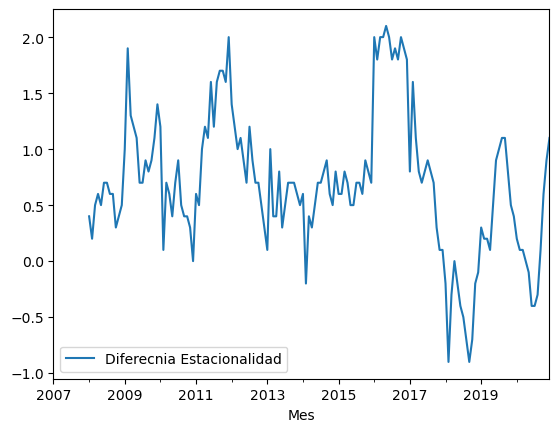

In [26]:
df_proyecto["Diferecnia Estacionalidad"].plot()
plt.legend()
plt.show()

In [27]:
prueba_adf(df_proyecto["Diferecnia Estacionalidad"].dropna())

Prueba de Dicky-Fuller Aumentado
Estadistico ADF:-2.440963411044124
p-value:0.13050689595851572
# de retrasos:12
Observaciones utilizadas:143
No se puede rechazar hipótesis nula
Los datos no son estacionarios


In [28]:
df_proyecto["Primera diferencia con estacionalidad"]= df_proyecto["Primera diferencia"]-df_proyecto["Primera diferencia"].shift(12)
df_proyecto.head(5)

,Litros por vaca,Primera diferencia,Segunda diferencia,Diferecnia Estacionalidad,Primera diferencia con estacionalidad
Mes,,,,,
2007-01-01,21.6,NaN,NaN,NaN,NaN
2007-02-01,20.6,-1.0,NaN,NaN,NaN
2007-03-01,23.5,2.9,3.9,NaN,NaN
2007-04-01,24.1,0.6,-2.3,NaN,NaN
2007-05-01,26.7,2.6,2.0,NaN,NaN


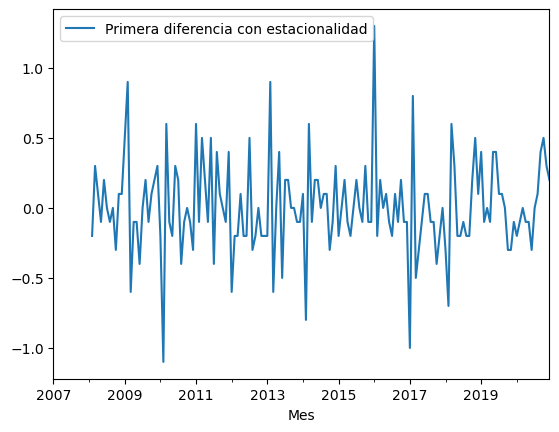

In [29]:
df_proyecto["Primera diferencia con estacionalidad"].plot()
plt.legend()
plt.show()

In [30]:
prueba_adf(df_proyecto["Primera diferencia con estacionalidad"].dropna())

Prueba de Dicky-Fuller Aumentado
Estadistico ADF:-4.87596584180041
p-value:3.883227114341381e-05
# de retrasos:11
Observaciones utilizadas:143
Se rechaza la hipótesis nula
Los datos son estacionarios
